In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table,Column,join
import time

import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('.'), '..')))

import fitIR
import fitIR.models as models
import fitIR.analyse as analyse

import pickle

import h5py
import glob

In [35]:
taskid = 20
batch_size = 2
low = taskid*batch_size
up = taskid*batch_size + (batch_size)

In [36]:
files_done = glob.glob('../data/*.pkl')
nums_done = []
for file in files_done:
    nums_done.append(int(file.replace('.pkl','').split('_')[-1]))
if taskid in nums_done:
    print('done already')

done already


In [37]:
inputs = h5py.File('../../greybody_input_EN1.h5','r')

In [46]:
ids = inputs['help_id'][low:up]
nums = inputs['num'][low:up]

names = ['Temperature_l','Temperature','Temperature_u','redshift_l','redshift','redshift_u','log10lir_l','log10lir','log10lir_u']

f_100 = inputs['f_pacs_green'][low:up]/1E6
f_160 = inputs['f_pacs_red'][low:up]/1E6
f_250 = inputs['f_spire_250'][low:up]/1E3
f_350 = inputs['f_spire_350'][low:up]/1E3
f_500 = inputs['f_spire_500'][low:up]/1E3

ferr_100 = inputs['ferr_pacs_green'][low:up]/1E6
ferr_160 = inputs['ferr_pacs_red'][low:up]/1E6
ferr_250 = inputs['ferr_spire_250'][low:up]/1E3
ferr_350 = inputs['ferr_spire_350'][low:up]/1E3
ferr_500 = inputs['ferr_spire_500'][low:up]/1E3

lamz = np.array([100., 160., 250., 350., 500.])

In [47]:
outputs = []

for n,num in enumerate(nums):
    print(n)
    fluxes = np.array([f_100[n], f_160[n], f_250[n], f_350[n], f_500[n]])
    print(fluxes)
    errors = np.array([ferr_100[n], ferr_160[n], ferr_250[n], ferr_350[n], ferr_500[n]])
    print(errors)
    
    mask = ~np.isnan(fluxes)
    
    obs = fitIR.observations(lamz[mask], fluxes[mask], errors[mask], cosmo)

    source = fitIR.source(obs, mod = 'greybody') 

    #read in the z pdf here
    z_pdf = h5py.File('../../HELP/dmu_products/dmu24/dmu24_ELAIS-N1/data/pz_hb_en1.hdf', 'r')
    cdf_y = np.cumsum(z_pdf['pz'][num])/np.sum(z_pdf['pz'][num])
    cdf_x = z_pdf['zgrid'].value
    z_pdf.close()
    
    if np.sum(np.isnan(cdf_y))==len(cdf_y):
        outputs.append(np.nan)
        print('no redshift pdf')
        continue

    source.prior_def['z'] = {'type': 'custom_pdf', 'cdf_x': cdf_y, 'cdf_y':cdf_x} # <---- to fix redshift
    #source.prior_def['z'] = {'type': 'uniform', 'limits': [2, 8]} 
    source.prior_def['log10LIR'] = {'type': 'uniform', 'limits': [8.,14.]}   
    source.prior_def['T'] = {'type': 'uniform', 'limits': [20.,60.]} 
    source.prior_def['emissivity'] = {'type': 'delta', 'value': 1.5} 

    output = source.fit()
    outputs.append(output)

0
[ 0.50840849  0.50005835  5.273572   12.821958    5.3930836 ]
[0.35389206 0.34904048 4.297421   4.562144   6.1509034 ]


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


1
[      nan       nan 1.7573419 1.395141  2.3594172]
[      nan       nan 2.1647157 1.759429  3.1764195]


T [21.60778725 25.72642587 41.13273015 54.97454449 58.45871274]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [0.65395588 1.19379346 2.97198793 5.91774261 6.66690661]
log10LIR [ 8.24414852  8.89428516 11.39030904 13.4857804  13.82933481]


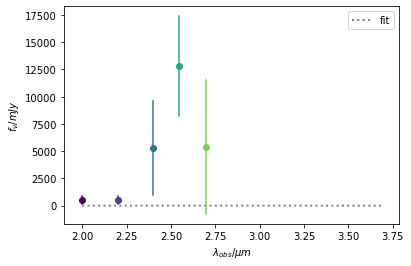

T
z
log10LIR


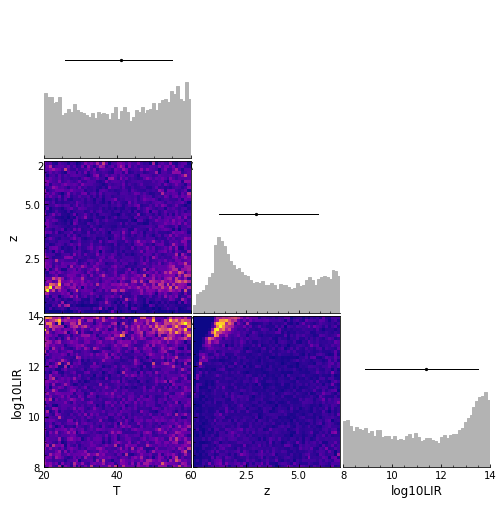

T [21.48923315 24.84256941 38.16407754 53.90113569 58.11206307]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [1.07306297 1.65261189 3.85343025 6.1675821  6.73487012]
log10LIR [ 8.21745595  8.78235527 11.01821986 13.25124203 13.79343321]


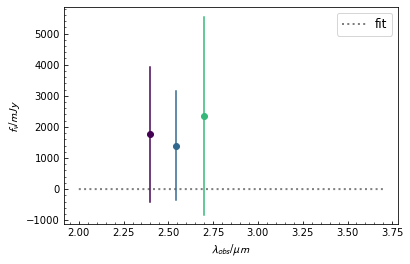

T
z
log10LIR


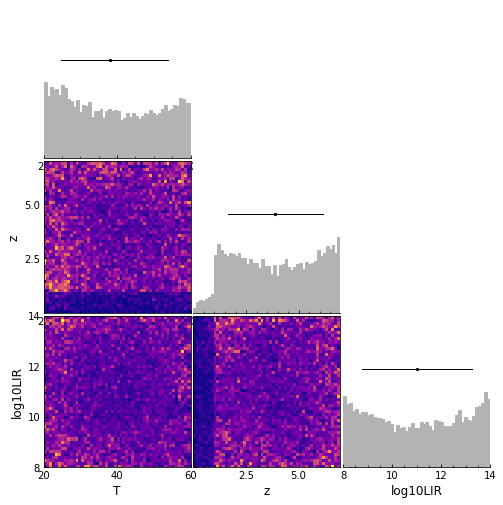

In [42]:
for source in outputs:
    a = analyse.analyser(source)

    P = a.P() # returns 5th, 16th, 50th, 84th, 95th percentile 
    for p in P.keys(): print(p, P[p])

    a.sed_plot()
    a.triangle_plot()

T [22.17970237 27.35386152 42.75234107 55.19383807 58.58486955]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [1.23826317 2.12447815 4.52249411 6.26284612 6.7562589 ]
log10LIR [ 8.48078307  9.5982185  12.11137944 12.89207219 13.10588289]


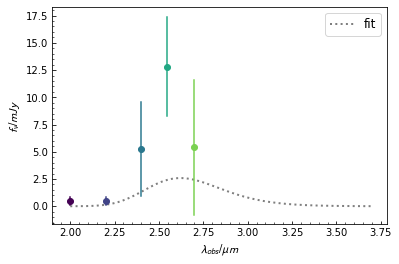

T
z
log10LIR


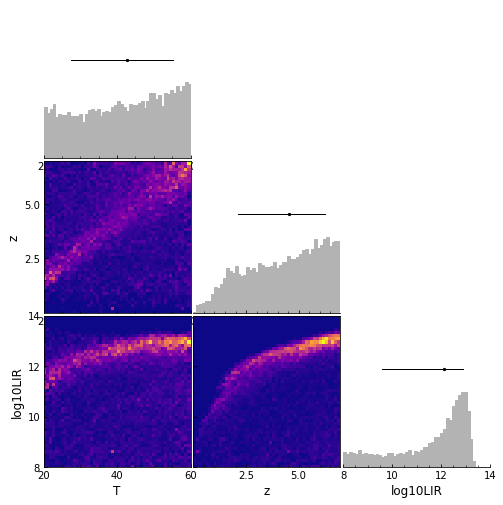

T [21.76064418 26.02538375 41.45665421 55.5542356  58.62940279]
emissivity [1.5 1.5 1.5 1.5 1.5]
z [1.10940198 1.80416265 4.23632348 6.24180972 6.74930598]
log10LIR [ 8.21918703  8.70498043 10.53415439 11.93400729 12.39087633]


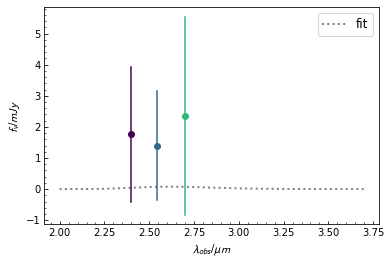

T
z
log10LIR


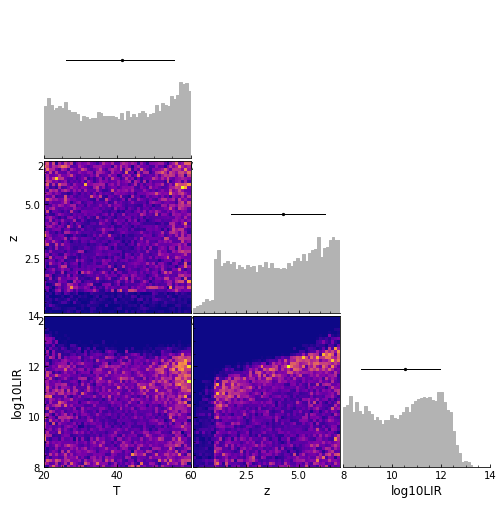

In [48]:
for source in outputs:
    a = analyse.analyser(source)

    P = a.P() # returns 5th, 16th, 50th, 84th, 95th percentile 
    for p in P.keys(): print(p, P[p])

    a.sed_plot()
    a.triangle_plot()

In [41]:
Table.read('../data/greybody_input_EN1.fits')

help_id,num,f_pacs_green,ferr_pacs_green,f_pacs_red,ferr_pacs_red,f_spire_250,ferr_spire_250,f_spire_350,ferr_spire_350,f_spire_500,ferr_spire_500
,,mJy,,mJy,,,,,,,
bytes1728,int64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
HELP_J155620.810+545113.308,2482323,nan,nan,nan,nan,20906.186999999998,3980.425000000003,26584.743,4480.207000000002,28536.203,5316.896000000001
HELP_J155622.752+545007.875,2629662,nan,nan,nan,nan,2092.5143,2675.7252,2062.2246,2575.2471,7125.304,4911.686
HELP_J155628.426+544936.570,2574853,nan,nan,nan,nan,57610.979999999996,3814.3070000000007,51566.753,4147.212999999996,35905.814999999995,4875.199999999993
HELP_J155628.601+545524.359,2699486,nan,nan,nan,nan,21767.074999999997,3945.0099999999984,28908.111999999997,4224.557999999997,29014.214,4922.216
HELP_J155631.071+545619.623,2469759,nan,nan,nan,nan,1423.2975999999999,1905.3827,975.4652,1316.3593999999998,3797.5717000000004,3478.171799999999
HELP_J155633.127+545753.634,2693692,nan,nan,nan,nan,5972.5614,4145.5055999999995,1523.9955,2294.7405,3110.4877,3816.1828999999993
HELP_J155633.669+544934.581,2577169,nan,nan,nan,nan,6786.080400000001,3455.5105999999996,2970.7122,2679.929800000001,2199.3911000000003,2840.5903000000003
HELP_J155633.728+545043.498,2630850,nan,nan,nan,nan,2945.7743,3704.1513999999997,2509.47,3254.6563,2519.6002000000003,3086.3507999999997
